In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
import jax_cosmo as jc
from flowpm.redshift import systematic_shift
from flowpm.tfbackground import rad_comoving_distance

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Generic redshift distribution
nzs=np.loadtxt("/global/u1/d/dlan/SkySim5000_IA_infusion/StageIV_zcen_nz_bin1-5.dat", unpack = True)

In [3]:
z=nzs[0]
nzs_s=nzs[1:]

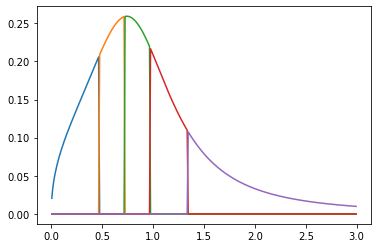

In [4]:
for i in range(len(nzs_s)):
    plot(z,nzs_s[i])


In [5]:
#Let's define some random z source
summ=0
for i in range(len(nzs_s)):
    summ=summ+nzs_s[i]

In [6]:
z_source_index=np.random.choice(np.arange(1,300),20)


In [7]:
z_source=[]
nz_source=[]
for i in z_source_index:
    z_source.append(z[i])
    nz_source.append(summ[i])

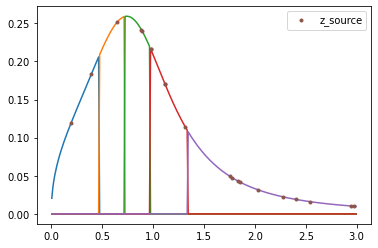

In [8]:
for i in range(len(nzs_s)):
    plot(z,nzs_s[i])
plot(z_source,nz_source,'.',label='z_source')
legend()

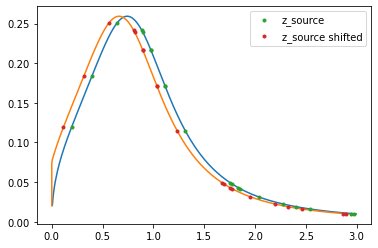

In [9]:
plot(z,summ)
plot(systematic_shift(z,0.08),summ)
plot(z_source,nz_source,'.',label='z_source')
plot(systematic_shift(z_source,0.08),nz_source,'.',label='z_source shifted')
legend()


## Let's Start the simulation

In [10]:
%pylab inline
%load_ext autoreload
%autoreload 2

import pickle
import tensorflow_addons as tfa
import tensorflow as tf
import flowpm
from flowpm.tfpower import linear_matter_power
import DifferentiableHOS as DHOS
from itertools import cycle
#from DifferentiableHOS.NLA_IA import  Epsilon2,Epsilon1,tidal_field,interpolation
#from flowpm.fourier_smoothing import fourier_smoothing
from flowpm.tfbackground import rad_comoving_distance

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from astropy.cosmology import Planck15
import astropy.units as u
from flowpm import tfpm
from flowpm.utils import cic_paint, compensate_cic
from flowpm.tfpower import linear_matter_power
from functools import partial
from flowpm.tfbackground import Omega_m_a, D1
import flowpm.constants as constants
from flowpm.fourier_smoothing import fourier_smoothing

In [12]:
# Loads PGD parameters
with open('/global/u1/d/dlan/DifferentiableHOS/notebooks/results_fit_PGD_205_128.pkl', "rb") as f:
    pgd_data = pickle.load(f)
    pgdparams = pgd_data['params']

In [13]:
# Below are a few parameters
n_lens = 11       # Number of lensplanes in the lightcone
box_size = 205.   # Transverse comoving size of the simulation volume
nc = 128          # Number of transverse voxels in the simulation volume
field_size = 5    # Size of the lensing field in degrees
field_npix = 1024 # Number of pixels in the lensing field 
batch_size = 1    # Number of simulations to run in parallel

In [14]:
# Instantiates a cosmology with desired parameters
cosmology = flowpm.cosmology.Planck15()
# Schedule the center of the lensplanes we want for ray tracing
r = tf.linspace(0., box_size*n_lens, n_lens+1)
r_center = 0.5*(r[1:] + r[:-1])
# Retrieve the scale factor corresponding to these distances
a = flowpm.tfbackground.a_of_chi(cosmology, r)
a_center =flowpm.tfbackground.a_of_chi(cosmology, r_center)
# We run 4 steps from initial scale factor to start of raytracing
init_stages = tf.linspace(0.1, a[-1], 4)
# Then one step per lens plane
stages = tf.concat([init_stages, a_center.numpy()[::-1]], axis=0)

In [15]:

#Create some initial conditions
initial_conditions = flowpm.linear_field([nc, nc, nc],
                                         [box_size, box_size, box_size], 
                                         lambda k: tf.cast(linear_matter_power(cosmology, k), tf.complex64),         
                                         batch_size=batch_size)
initial_state = flowpm.lpt_init(cosmology, initial_conditions, 0.1)

In [16]:
# Run the Nbody
states = flowpm.nbody(cosmology, 
                      initial_state, 
                      stages,
                      [nc, nc, nc],
                      return_intermediate_states=True,
                      pgdparams=None) 

In [17]:
%%time
# Extract the lensplanes
lensplanes = []
matrix = flowpm.raytracing.rotation_matrices()
for i, j in zip(range(len(a_center)), cycle(range(6))):
    plane = flowpm.raytracing.density_plane(states[::-1][i][1],
                                            [nc, nc, nc],
                                            nc//2,
                                            width=nc,
                                            plane_resolution=2048,
                                            rotation=matrix[j],
                                            shift=flowpm.raytracing.random_2d_shift())
    plane = fourier_smoothing(plane,sigma=1.024,resolution=2048)
    lensplanes.append((r_center[i], states[::-1][i][0], plane))

CPU times: user 51.5 s, sys: 31.1 s, total: 1min 22s
Wall time: 35.7 s


In [18]:
%%time
# Get convergence map
import astropy.units as u
xgrid, ygrid = np.meshgrid(np.linspace(0, field_size, field_npix, endpoint=False), # range of X coordinates
                           np.linspace(0, field_size, field_npix, endpoint=False)) # range of Y coordinates

coords = np.stack([xgrid, ygrid], axis=0)*u.deg
c = coords.reshape([2, -1]).T.to(u.rad)
m_array=[]
for i in range(len(z_source)):
    m = flowpm.raytracing.convergenceBorn(cosmology, 
                        lensplanes, 
                        dx=box_size/2048, 
                        dz=box_size,
                        coords=c,
                        z_source=z_source[i])
    m= tf.reshape(m, [batch_size, field_npix,field_npix])
    m_array.append(m)

CPU times: user 1min 46s, sys: 24.4 s, total: 2min 10s
Wall time: 27.2 s


In [19]:
def tomo_kappa(m_ar,nz_s):
    tom_kappa=0
    for i in range(len(m_array)):
        tom_kappa=tom_kappa+(nz_s[i]*m_array[i][0])
    return tom_kappa

In [20]:
k_tom=tomo_kappa(m_array,nz_source)

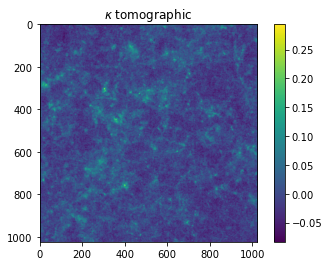

In [21]:
imshow(k_tom)
title('$\kappa$ tomographic')
colorbar()